# SES 130: Coding for Exploration, Lab <#>

In this lab, we're going to use Logistic Regression to classify pixels into different land cover classes.

In [69]:
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import rasterio 
from rasterio import plot
import gdal
from gdalconst import GA_ReadOnly

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

HEIGHT = 3660
WIDTH = 3660
N_BANDS = 8

# 1. Prepare the dataset

## Load the input data

### Landsat-8 Images

Landsat-8 is an imaging satellite operated and freely distributed by the USGS. The Landsat-8 bands we want to make use of are:
* blue
* green
* red
* nir_narrow
* swir1 (1600 nm)
* swir2 (~2100 nm)

We've also pre-computed two common band ratios, Normalized Difference Vegetation Index (NDVI) and Green Chlorophyll Vegetation Index (GCVI), which are helpful for discerning plant phenology and health.

### Load a relatively cloud-free Landsat image in growing season

In [2]:
# Define the directory containing the data
fp_illinois = '/gpfs/data1/cmongp1/hkerner/teaching/landsat_illinois'

# Define the path template for the image
l30_path = 'HLS.L30.T16TBL.2018204.v1.4_%s.tif'

# Create an np.array to hold the 8 bands (all tiles are 3660 x 3660)
l30_img = np.ndarray([HEIGHT, WIDTH, N_BANDS])

bands = ['blue', 'green', 'red', 'nir_narrow', 'swir1', 'swir2', 'ndvi', 'gcvi']

# Load each band into the array
for i, band in enumerate(bands):
    l30_fp = os.path.join(fp_illinois, l30_path % (band))
    l30_raster = rasterio.open(l30_fp)
    l30_img[:,:,i] = l30_raster.read(1)
    # Clip the GCVI values to -1, 20
    if band == 'gcvi':
        l30_img[:,:,i] = np.clip(l30_img[:,:,i], -1, 20)
    
print l30_raster.meta

{'count': 1, 'crs': CRS.from_epsg(32616), 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(30.0, 0.0, 199980.0,
       0.0, -30.0, 4600020.0), 'height': 3660, 'width': 3660, 'nodata': nan}


### Display the image to see what it looks like

We can display single bands as grayscale images.

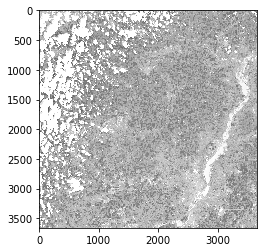

In [3]:
fig, ax = plt.subplots(1)
ax.imshow(l30_img[...,3], cmap=plt.cm.Greys)

We can also display single bands with a color map to help bring out different attributes in the image. You can find a list of Matplotlib color maps here and choose one to your liking: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

Note that we are also zooming in on the image by selecting a subset of the total image frame to display.

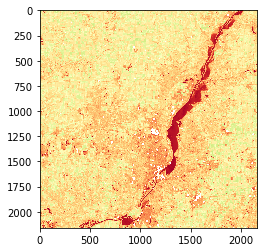

In [4]:
fig, ax = plt.subplots(1)
ax.imshow(l30_img[1500:,1500:,3], cmap='RdYlGn')

We may also want to view an image in "true color" for us humans, which is RGB (red, green, blue). To do this, we can create a new image with only these bands selected.

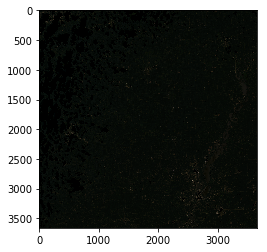

In [5]:
img = np.take(l30_img, [2,1,0], axis=2)

# Display the image
fig, ax = plt.subplots(1)
ax.imshow(img)

Yikes - we can't see anything! This is because while the reflectance values for each band all are in the range (0, 1), there are some outlier values that cause the image to appear black when Matplotlib tries to scale the colormap. 

To fix this, we can set a threshold on the reflectance values.

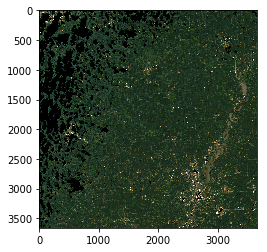

In [6]:
# Select the red, green, and blue bands
img = np.take(l30_img, [2,1,0], axis=2)

# Pixels that have clouds or no data are NaN - we need to set these to 0 before rescaling
img[np.where(np.isnan(img))] = 0

# Empirically set a threshold to scale the image values
max_val = 0.2
for band in range(img.shape[-1]):
    img[np.where(img[...,band] > max_val)] = max_val
    img[...,band] = np.interp(img[...,band], (img[...,band].min(), img[...,band].max()), (0,1))

# Display the image
fig, ax = plt.subplots(1)
ax.imshow(img)

## Load the land cover labels

### Land cover classification for agriculture

The Cropland Data Layer (CDL) provides crop type/land cover classes at 30 m/px resolution for the US each year. It is created by the USDA NASS and is released to the public a few months after the end of the growing season (i.e., the following year). The CDL assigns one of its >100 crop-specific land cover classes to each pixel. You can find the documentation for the CDL here: https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL

We've provided a GeoTIFF of the CDL for the entire state of Illinois (CDL_2018_illinois.tif). To match the pixel-level labels to our Landsat image, we want to align and crop it to be the same area as our Landsat scene. We'll do this using GDAL.

In [9]:
# Re-load one of our Landsat scenes using GDAL
data = gdal.Open(os.path.join(fp_illinois, l30_path % 'ndvi'), GA_ReadOnly)

# Get the transform info
geoTransform = data.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize

# Crop CDL raster to this tile bounds
try:
    subprocess.check_output('gdal_translate -projwin ' + ' '.join([str(x) for x in [minx, maxy, maxx, miny]]) + ' -of GTiff CDL_2018_illinois.tif CDL_2018_illinois_crop.tif', shell=True)
except subprocess.CalledProcessError as e:
    raise RuntimeError("command '{}' return with error (code {}): {}".format(e.cmd, e.returncode, e.output))

    # Load the cropped raster
cdl_2018 = rasterio.open('CDL_2018_illinois_crop.tif')
cdl_labels = cdl_2018.read(1)

### Display the land cover labels

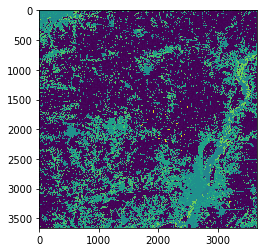

In [10]:
fig, ax = plt.subplots(1)
ax.imshow(cdl_labels)

## Select classes and features

There are many land cover classes in our study area, but for simplicity we'll start with two pretty common ones: water and deciduous forest. The values for these classes in the CDL can be found in the documentation provided earlier: water = 111 and deciduous forest = 141. 

You can read the documentation to see the values for other types of land cover and see where they are in our study area!

### Display only the pixels that contain water

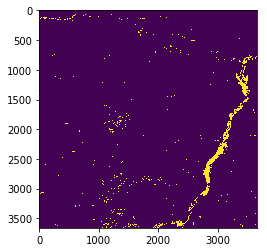

In [16]:
# Create an empty array to hold the mask
water_mask = np.zeros(cdl_labels.shape)
# Set all the pixels in the mask to 1 that correspond to water
water_mask[np.where(cdl_labels==111)] = 1

fig, ax = plt.subplots(1)
ax.imshow(water_mask)

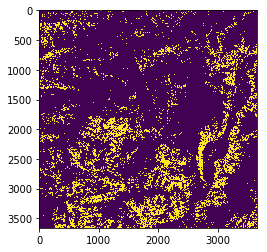

In [17]:
# Create an empty array to hold the mask
forest_mask = np.zeros(cdl_labels.shape)
# Set all the pixels in the mask to 1 that correspond to deciduous forest
forest_mask[np.where(cdl_labels==141)] = 1

fig, ax = plt.subplots(1)
ax.imshow(forest_mask)

### Select input features

When we build our Logistic Regression classifier, we want to give it the best chance for success. Since logistic regression is a linear classifier, this means that we want to provide the model with input features that are most linearly separable (i.e., we can draw a dividing line that has most of the forest pixels on one side and most of the water pixels on the other side).

For simplicity, we're going to pick two features to give as input to our classifier. How do we choose what two features to use?

Our available features are the reflectances in each of the 6 Landsat-8 bands and the 2 spectral indices (NDVI and GCVI). One way to visualize which two features will make the classes most linearly separable is to plot all combinations of two features. Clearly, this approach becomes less feasible the more features you have, but in this case it is a good approach.

First, we need to grab the subset of pixels in our Landsat scene that correspond with water or forest.

In [32]:
# Select the pixels in the Landsat image that have water or forest
water_pixels = l30_img[np.where(cdl_labels==111)]
print(water_pixels.shape)
forest_pixels = l30_img[np.where(cdl_labels==141)]
print(forest_pixels.shape)

(275587, 8)
(2095772, 8)


Notice the size of these datasets--there are >2 million forest pixels! This is too many for the Matplotlib graphics engine, so we'll select a random subset of them to display. 

In [19]:
water_subset = np.random.permutation(water_pixels)[:500]
forest_subset = np.random.permutation(forest_pixels)[:500]

Plot a scatter plot for every feature combination and color pixels that represent forest green and those that represent water blue.

Text(0.5,0.98,'Water/Forest Separability in Landsat-8 Band Combinations')

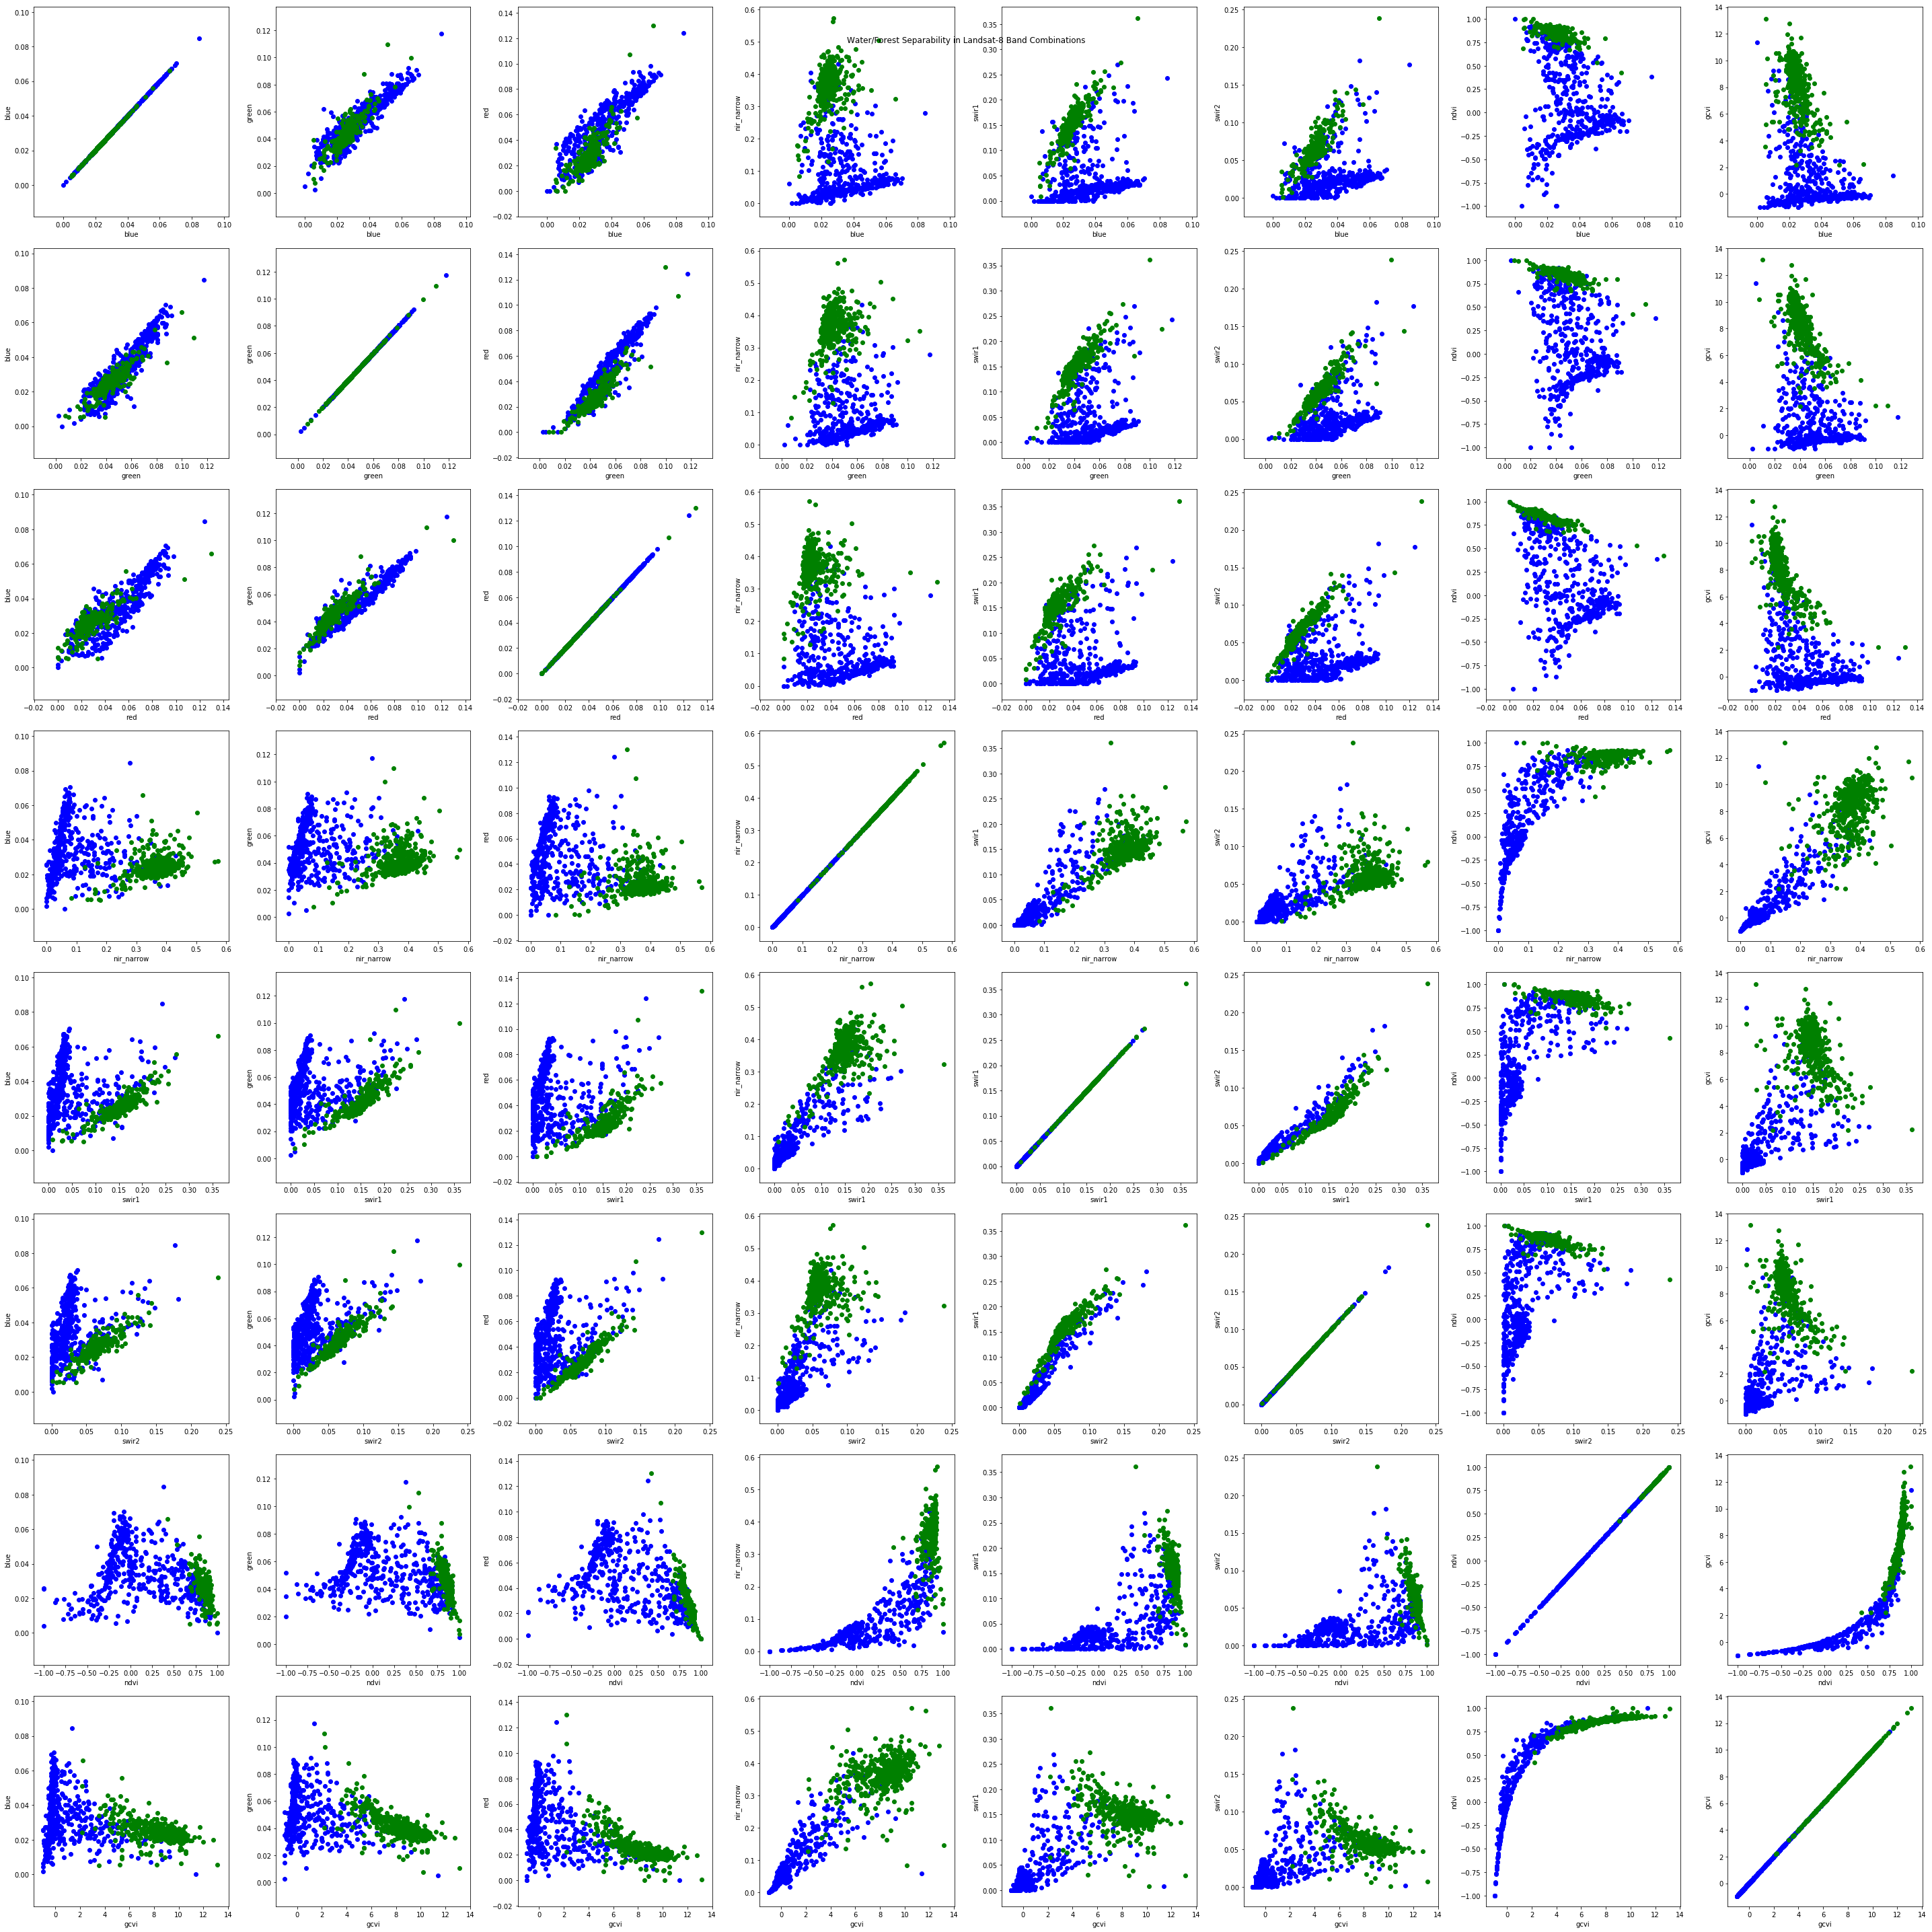

In [15]:
# Feature selection:
# Plot all bands against each other to see which give the best separation
fig, ax = plt.subplots(nrows=N_BANDS, ncols=N_BANDS, figsize=[40,40])

for i in range(N_BANDS):
    for j in range(N_BANDS):
        ax[i,j].scatter(water_subset[...,i], water_subset[...,j], color='blue')
        ax[i,j].scatter(forest_subset[...,i], forest_subset[...,j], color='green')
        ax[i,j].set_xlabel(bands[i])
        ax[i,j].set_ylabel(bands[j])

fig.tight_layout()
fig.suptitle("Water/Forest Separability in Landsat-8 Band Combinations")

Which of these feature combinations most looks like you could draw a line to separate most of the green (forest) from the blue (water) pixels?

It looks like GCVI vs. NIR might be a good choice!

Text(0,0.5,'gcvi')

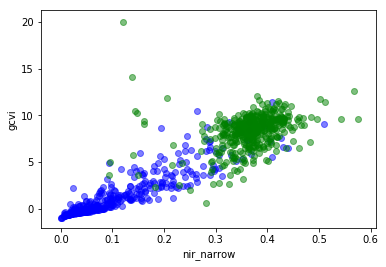

In [21]:
fig, ax = plt.subplots(1)
ax.scatter(water_subset[...,3], water_subset[...,7], color='blue', alpha=0.5)
ax.scatter(forest_subset[...,3], forest_subset[...,7], color='green', alpha=0.5)
ax.set_xlabel(bands[3])
ax.set_ylabel(bands[7])

## Train the classifier

Before we train our classifier (i.e., fit the parameters of the logistic function), we need to separate our data into training and test data. One way to do this is to set aside a random 20% of the data in each class for testing.

In [33]:
# First, delete all the NaN examples
water_pixels = np.delete(water_pixels, np.where(np.isnan(water_pixels))[0], axis=0)
forest_pixels = np.delete(forest_pixels, np.where(np.isnan(forest_pixels))[0], axis=0)

In [34]:
water_shuffled = np.random.permutation(water_pixels)
water_test = water_shuffled[:int(water_pixels.shape[0]*0.2)]
water_train = water_shuffled[int(water_pixels.shape[0]*0.2):]
print(water_test.shape)
print(water_train.shape)

forest_shuffled = np.random.permutation(forest_pixels)
forest_test = forest_shuffled[:int(forest_pixels.shape[0]*0.2)]
forest_train = forest_shuffled[int(forest_pixels.shape[0]*0.2):]

print(forest_test.shape)
print(forest_train.shape)

(52908, 8)
(211632, 8)
(382382, 8)
(1529530, 8)


Now, we'll separately combine the training and test examples (X) along with the labels (y). Since we are building a binary classifier, we will make the label for water = 0 and the label for forest = 1.

In [38]:
X_train = np.concatenate([water_train, forest_train])
y_train = np.concatenate([np.zeros(water_train.shape[0]), np.ones(forest_train.shape[0])])

In [39]:
X_test = np.concatenate([water_test, forest_test])
y_test = np.concatenate([np.zeros(water_test.shape[0]), np.ones(forest_test.shape[0])])

Since we are only using GCVI and NIR, not all the features, we will select those bands from our data.

In [42]:
X_train = np.take(X_train, [3,7], axis=1)
X_test = np.take(X_test, [3,7], axis=1)

In [43]:
print(X_train.shape)
print(X_test.shape)

(1741162, 2)
(435290, 2)


Now we can fit our classifier to the training data. We'll use the Logistic Regression class provided in Scikit-learn, which is a powerful library for machine learning in python.

In [44]:
clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)

We just fit the coefficients and intercept of our decision function based on our training data. How well did it do? 

Let's plot a scatter plot of our test data features.

Text(0,0.5,'GCVI')

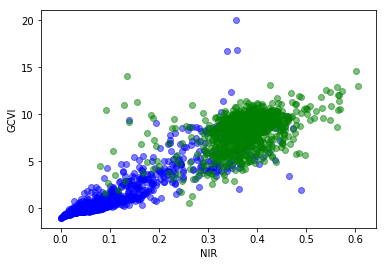

In [54]:
water_test = X_test[np.where(y_test == 0)]
forest_test = X_test[np.where(y_test == 1)]

fig, ax = plt.subplots(1)

ax.scatter(water_test[:1000,0], water_test[:1000,1], color='blue', alpha=0.5)
ax.scatter(forest_test[:1000,0], forest_test[:1000,1], color='green', alpha=0.5)
ax.set_xlabel('NIR')
ax.set_ylabel('GCVI')

In [55]:
clf.coef_

array([[13.62338177,  0.5624671 ]])

Now, using our learned coefficients, we'll draw the decision boundary. Since one of our features will be represented on the y axis, our decision function has the form:
w[1] * y = w[0] * x + b 

Solving for y, we get the equation of the line we want to plot:
y = (w[0] * x)/w[1] + b / w[1]

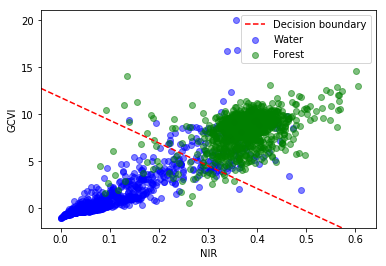

In [63]:
fig, ax = plt.subplots(1)

ax.scatter(water_test[:1000,0], water_test[:1000,1], color='blue', label='Water', alpha=0.5)
ax.scatter(forest_test[:1000,0], forest_test[:1000,1], color='green', label='Forest', alpha=0.5)
ax.set_xlabel('NIR')
ax.set_ylabel('GCVI')

ax.autoscale(False)
x_vals = np.array(ax.get_xlim())
y_vals = -(clf.coef_[0][0] * x_vals + clf.intercept_[0]) / clf.coef_[0][1]
ax.plot(x_vals, y_vals, '--', c="red", label='Decision boundary')
ax.legend()

Visually, this looks like our decision function will work pretty well for our test set! To actually test this, we need to use our classifier to predict class labels for our test examples and compute the accuracy. 

In [65]:
# Get the test set predictions
y_pred = clf.predict(X_test)

In [66]:
print("Accuracy on test set = %f" % accuracy_score(y_pred=y_pred, y_true=y_test))

Accuracy on test set = 0.952489


Pretty darn good! Other useful metrics when evaluating classifiers is "precision" and "recall". Let TP represent True Positives and FP represent False Positives. Precision = TP / (TP+FP). Let FN represent False Negatives. Recall = TP / (TP+FN).

In [70]:
print("Precision on test set = %f" % precision_score(y_pred=y_pred, y_true=y_test))

Precision on test set = 0.988277


In [71]:
print("Recall on test set = %f" % recall_score(y_pred=y_pred, y_true=y_test))

Recall on test set = 0.957270


Ideally, we want to balance precision and recall when optimizing a classifier. The F1 score is the harmonic mean of precision and recall and is often used to measure this balance.

In [72]:
print("F1 Score on test set = %f" % f1_score(y_pred=y_pred, y_true=y_test))

F1 Score on test set = 0.972527


# Exercise 1: Exploring other features

We chose to use NIR reflectance and GCVI as input features for our classifier, but there were many other feature combinations we could have chosen. Choose a different set of features to use and train the logistic regression model. How does the accuracy and F1 score compare between our NIR/GCVI-based model and the one you chose? Report these metrics and plot the test data with learned decision boundary.

# Exercise 2: Exploring other classes

We chose to look at pixels in our original Landsat scene that represented water and deciduous forests, but there are many other land cover classes in the image that are described in the CDL documentation. Look at the CDL documentation to see what these other classes are, and choose two new classes. Train a logistic regression classifier (using two features of your choice) to separate these classes. Which features did you use and why? How well are you able to separate these classes compared to the forest/water classes we chose earlier?